In [2]:
"""
This script demonstrates the use of `LeRobotDataset` class for handling and processing robotic datasets from Hugging Face.
It illustrates how to load datasets, manipulate them, and apply transformations suitable for machine learning tasks in PyTorch.

Features included in this script:
- Viewing a dataset's metadata and exploring its properties.
- Loading an existing dataset from the hub or a subset of it.
- Accessing frames by episode number.
- Using advanced dataset features like timestamp-based frame selection.
- Demonstrating compatibility with PyTorch DataLoader for batch processing.

The script ends with examples of how to batch process data using PyTorch's DataLoader.
"""

from pprint import pprint

import torch
from huggingface_hub import HfApi

import lerobot
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata


In [3]:
# We ported a number of existing datasets ourselves, use this to see the list:
print("List of available datasets:")
if 'lerobot/pusht' in lerobot.available_datasets:
    idx = lerobot.available_datasets.index('lerobot/pusht')
    print(lerobot.available_datasets[idx])
else:
    print("pusht dataset is not available")


List of available datasets:
lerobot/pusht


In [4]:
# You can also browse through the datasets created/ported by the community on the hub using the hub api:
hub_api = HfApi()

repo_ids = [info.id for info in hub_api.list_datasets(task_categories="robotics", tags=["LeRobot"])]
if 'lerobot/pusht' in repo_ids:
    idx = repo_ids.index('lerobot/pusht')
    print(repo_ids[idx])
else:
    print("pusht dataset is not available")

/home/xipengw/miniconda3/envs/lerobot/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'list_datasets': tags. Will not be supported from version '1.0'.

Use `filter` instead.
  warnings.warn(message, FutureWarning)


lerobot/pusht


In [5]:
# Or simply explore them in your web browser directly at:
# https://huggingface.co/datasets?other=LeRobot

# Let's take this one for this example
repo_id = "lerobot/pusht"
# We can have a look and fetch its metadata to know more about it:
ds_meta = LeRobotDatasetMetadata(repo_id)

# By instantiating just this class, you can quickly access useful information about the content and the
# structure of the dataset without downloading the actual data yet (only metadata files — which are
# lightweight).

# print(f"Total number of episodes: {ds_meta.total_episodes}")
# print(f"Average number of frames per episode: {ds_meta.total_frames / ds_meta.total_episodes:.3f}")
# print(f"Frames per second used during data collection: {ds_meta.fps}")
# print(f"Robot type: {ds_meta.robot_type}")
print(f"keys to access images from cameras: {ds_meta.camera_keys=}\n")

# print("Tasks:")
# print(ds_meta.tasks)
# print("Features:")
# pprint(ds_meta.features)

# You can also get a short summary by simply printing the object:
print(ds_meta)

keys to access images from cameras: ds_meta.camera_keys=['observation.image']

LeRobotDatasetMetadata({
    Repository ID: 'lerobot/pusht',
    Total episodes: '206',
    Total frames: '25650',
    Features: '['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index', 'task_index']',
})',



In [6]:
# You can then load the actual dataset from the hub.
# Either load any subset of episodes:
dataset = LeRobotDataset(repo_id, episodes=[0, 200])
# And see how many frames you have:
print(f"Selected episodes: {dataset.episodes}")
print(f"Number of episodes selected: {dataset.num_episodes}")
print(f"Number of frames selected: {dataset.num_frames}")

Selected episodes: [0, 200]
Number of episodes selected: 2
Number of frames selected: 25650


In [7]:
# Or simply load the entire dataset:
dataset = LeRobotDataset(repo_id)
print(f"Number of episodes selected: {dataset.num_episodes}")
print(f"Number of frames selected: {dataset.num_frames}")

Number of episodes selected: 206
Number of frames selected: 25650


In [8]:
# The previous metadata class is contained in the 'meta' attribute of the dataset:
print(dataset.meta)

LeRobotDatasetMetadata({
    Repository ID: 'lerobot/pusht',
    Total episodes: '206',
    Total frames: '25650',
    Features: '['observation.image', 'observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index', 'task_index']',
})',



In [9]:
# LeRobotDataset actually wraps an underlying Hugging Face dataset
# (see https://huggingface.co/docs/datasets for more information).
print(dataset.hf_dataset)

Dataset({
    features: ['observation.state', 'action', 'episode_index', 'frame_index', 'timestamp', 'next.reward', 'next.done', 'next.success', 'index', 'task_index'],
    num_rows: 25650
})


In [10]:
# LeRobot datasets also subclasses PyTorch datasets so you can do everything you know and love from working
# with the latter, like iterating through the dataset.
# The __getitem__ iterates over the frames of the dataset. Since our datasets are also structured by
# episodes, you can access the frame indices of any episode using dataset.meta.episodes. Here, we access
# frame indices associated to the first episode:
episode_index = 0
from_idx = dataset.meta.episodes["dataset_from_index"][episode_index]
to_idx = dataset.meta.episodes["dataset_to_index"][episode_index]
print(from_idx, to_idx)

0 161


In [11]:
# Then we grab all the image frames from the first camera:
camera_key = dataset.meta.camera_keys[0]
frames = [dataset[idx][camera_key] for idx in range(from_idx, to_idx)]
# The objects returned by the dataset are all torch.Tensors
print(type(frames[0]))
print(frames[0].shape)

<class 'torch.Tensor'>
torch.Size([3, 96, 96])


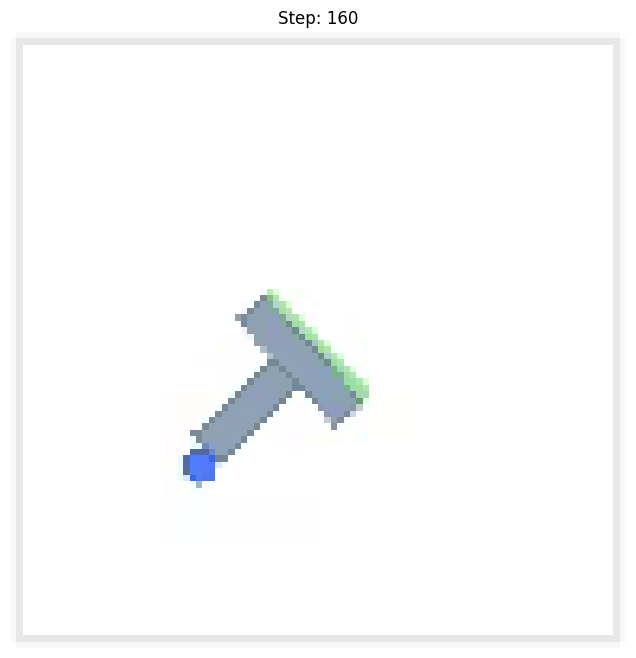

<Figure size 800x800 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

plt.figure(figsize=(8, 8))

for frame_idx in range(0, len(frames)):
    image = frames[frame_idx].permute(1, 2, 0).cpu().numpy()
    # Display every frame slowly
    clear_output(wait=True)
    plt.clf()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Step: {frame_idx}')
    display(plt.gcf())
    # Add delay to slow down the rendering (adjust this value as needed)
    time.sleep(0.01)  # 0.1 seconds = 10 FPS, increase for slower rendering
plt.clf()

In [13]:
# Since we're using pytorch, the shape is in pytorch, channel-first convention (c, h, w).
# We can compare this shape with the information available for that feature
pprint(dataset.features[camera_key])
# In particular:
print(dataset.features[camera_key]["shape"])
# The shape is in (h, w, c) which is a more universal format.

{'dtype': 'video',
 'names': ['height', 'width', 'channel'],
 'shape': (96, 96, 3),
 'video_info': {'has_audio': False,
                'video.codec': 'av1',
                'video.fps': 10.0,
                'video.is_depth_map': False,
                'video.pix_fmt': 'yuv420p'}}
(96, 96, 3)


In [14]:
# For many machine learning applications we need to load the history of past observations or trajectories of
# future actions. Our datasets can load previous and future frames for each key/modality, using timestamps
# differences with the current loaded frame. For instance:
delta_timestamps = {
    # loads 4 images: 1 second before current frame, 500 ms before, 200 ms before, and current frame
    camera_key: [-1, -0.5, -0.20, 0],
    # loads 6 state vectors: 1.5 seconds before, 1 second before, ... 200 ms, 100 ms, and current frame
    "observation.state": [-1.5, -1, -0.5, -0.20, -0.10, 0],
    # loads 64 action vectors: current frame, 1 frame in the future, 2 frames, ... 63 frames in the future
    "action": [t / dataset.fps for t in range(64)],
}

In [18]:
# Note that in any case, these delta_timestamps values need to be multiples of (1/fps) so that added to any
# timestamp, you still get a valid timestamp.

dataset = LeRobotDataset(repo_id, delta_timestamps=delta_timestamps)
print(f"\n{dataset[0][camera_key].shape=}")  # (4, c, h, w)
print(f"{dataset[0]['observation.state'].shape=}")  # (6, c)
print(f"{dataset[0]['action'].shape=}\n")  # (64, c)


dataset[0][camera_key].shape=torch.Size([4, 3, 96, 96])
dataset[0]['observation.state'].shape=torch.Size([6, 2])
dataset[0]['action'].shape=torch.Size([64, 2])



In [19]:
# Finally, our datasets are fully compatible with PyTorch dataloaders and samplers because they are just
# PyTorch datasets.
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=32,
    shuffle=True,
)

for batch in dataloader:
    print(f"{batch[camera_key].shape=}")  # (32, 4, c, h, w)
    print(f"{batch['observation.state'].shape=}")  # (32, 6, c)
    print(f"{batch['action'].shape=}")  # (32, 64, c)
    break


batch[camera_key].shape=torch.Size([32, 4, 3, 96, 96])
batch['observation.state'].shape=torch.Size([32, 6, 2])
batch['action'].shape=torch.Size([32, 64, 2])


In [51]:
from pathlib import Path

import torch

from lerobot.configs.types import FeatureType
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.policies.diffusion.modeling_diffusion import DiffusionPolicy
from lerobot.policies.factory import make_pre_post_processors

In [52]:
# Create a directory to store the training checkpoint.
output_directory = Path("outputs/train/example_pusht_diffusion")
output_directory.mkdir(parents=True, exist_ok=True)

In [53]:
# # Select your device
assert torch.cuda.is_available(), "No GPU available"
device = torch.device("cuda")
device_str = "cuda"  # Use string for config, torch.device for actual operations
# Number of offline training steps (we'll only do offline training for this example.)
# Adjust as you prefer. 5000 steps are needed to get something worth evaluating.
training_steps = 5000
log_freq = 500

In [54]:
# When starting from scratch (i.e. not from a pretrained policy), we need to specify 2 things before
# creating the policy:
#   - input/output shapes: to properly size the policy
#   - dataset stats: for normalization and denormalization of input/outputs
dataset_metadata = LeRobotDatasetMetadata("lerobot/pusht")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

In [56]:
# Policies are initialized with a configuration class, in this case `DiffusionConfig`. For this example,
# we'll just use the defaults and so no arguments other than input/output features need to be passed.
cfg = DiffusionConfig(input_features=input_features, 
                      output_features=output_features, 
                      device=device_str)

In [57]:
# We can now instantiate our policy with this config and the dataset stats.
policy = DiffusionPolicy(cfg)
policy.train()
policy.to(device)
preprocessor, postprocessor = make_pre_post_processors(cfg, dataset_stats=dataset_metadata.stats)

In [58]:
# In this case with the standard configuration for Diffusion Policy, it is equivalent to this:
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.image": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}

In [59]:
# Another policy-dataset interaction is with the delta_timestamps. Each policy expects a given number frames
# which can differ for inputs, outputs and rewards (if there are some).
delta_timestamps = {
    "observation.image": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "observation.state": [i / dataset_metadata.fps for i in cfg.observation_delta_indices],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}


In [60]:
# We can then instantiate the dataset with these delta_timestamps configuration.
dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps, 
                        video_backend="pyav")

In [61]:
# Then we create our optimizer and dataloader for offline training.
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=4,
    batch_size=64,
    shuffle=True,
    pin_memory=device.type != "cpu",
    drop_last=True,
)


In [ ]:
# Run training loop.
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.io._video_deprecation_warning')

step = 0
done = False
while not done:
    for batch in dataloader:
        batch = preprocessor(batch)
        loss, _ = policy.forward(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % log_freq == 0:
            print(f"step: {step} loss: {loss.item():.3f}")
        step += 1
        if step >= training_steps:
            done = True
            break

In [53]:
policy.save_pretrained(output_directory)
preprocessor.save_pretrained(output_directory)
postprocessor.save_pretrained(output_directory)

In [4]:
# Load the trained model and test on PushT environment
import gymnasium as gym
import numpy as np
from pathlib import Path

# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. SmolVLA requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Load the trained policy
pretrained_policy_path = Path("outputs/train/example_pusht_diffusion")
policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
policy.eval()
policy.to(device)
print(f"Number of trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
Loading weights from local directory
Number of trainable parameters: 262,709,026


In [5]:


preprocessor, postprocessor = make_pre_post_processors(policy.config, pretrained_path=pretrained_policy_path)

print(f"Model loaded from {pretrained_policy_path}")
print(f"Policy device: {next(policy.parameters()).device}")

# Create the PushT environment
try:
    import gym_pusht
    env = gym.make("gym_pusht/PushT-v0", render_mode="rgb_array", obs_type="pixels_agent_pos")
    print("PushT environment created successfully")
except ImportError:
    print("Warning: gym_pusht not installed. Install with: pip install gym-pusht")
    env = None
except Exception as e:
    print(f"Error creating environment: {e}")
    env = None


Model loaded from outputs/train/example_pusht_diffusion
Policy device: cuda:0
PushT environment created successfully


In [12]:
# Reset the environment
observation, info = env.reset(seed=42)
# Reset the policy's internal queue at the start of each episode
policy.reset()
episode_reward = 0
frames_for_video = []
max_steps = 500
log_freq = 100
for step in range(max_steps):
    # Get current observation
    current_image = torch.from_numpy(observation["pixels"]).float() / 255.0
    frames_for_video.append(current_image)
    # Normalize image from [0, 255] to [0, 1] and permute to (C, H, W) for torch input
    current_image = current_image.permute(2, 0, 1)
    current_state = torch.from_numpy(observation["agent_pos"]).float()

    # Build observation dict for policy (single timestep, no temporal stacking)
    # The policy's queue mechanism will handle the temporal dimension
    # Shape: [batch, channels, height, width] for images, [batch, state_dim] for state

    # Check input features
    # print(input_features.keys())
    batch = {
        "observation.image": current_image.unsqueeze(0).to(device),  # [1, C, H, W]
        "observation.state": current_state.unsqueeze(0).to(device),  # [1, state_dim]
    }

    # Get action from policy
    actions = None
    with torch.no_grad():
        batch = preprocessor(batch)
        actions = policy.select_action(batch)
        actions = postprocessor(actions)
        # Execute action in environment
    assert actions is not None
    action = actions[0].cpu().numpy()
    observation, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    success = info.get("success", False)
    if step % log_freq == 0:
        print(f"Reward = {episode_reward:.2f}, Success = {success}, Steps = {step + 1}")
    if success:
        print(f"Reward = {episode_reward:.2f}, Success = {success}, Steps = {step + 1}")
        break
    if terminated or truncated:
        break
 
    # Execute action in environment

Reward = 0.00, Success = False, Steps = 1
Reward = 9.32, Success = False, Steps = 101
Reward = 84.63, Success = False, Steps = 201


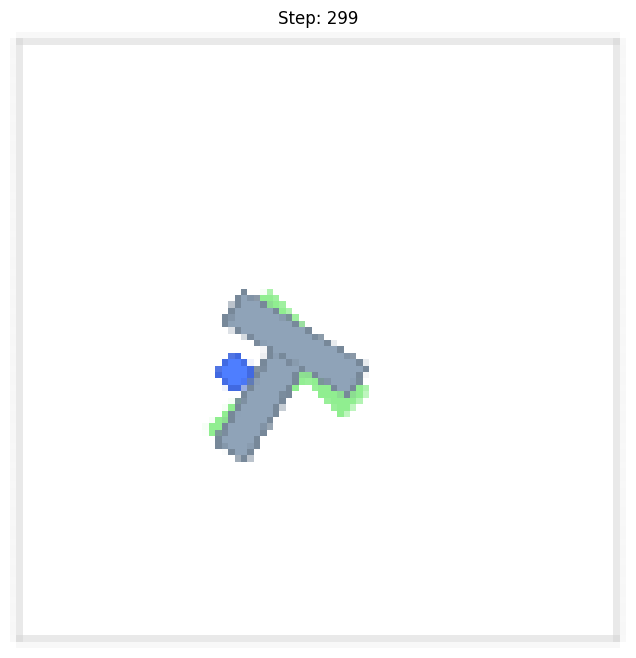

<Figure size 800x800 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

print("Visualizing first episode...")
plt.figure(figsize=(8, 8))
for frame_idx in range(0, len(frames_for_video)):
    image = frames_for_video[frame_idx]
    # Display every frame slowly
    clear_output(wait=True)
    plt.clf()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Step: {frame_idx}')
    display(plt.gcf())
    # Add delay to slow down the rendering (adjust this value as needed)
    time.sleep(0.01)  # 0.1 seconds = 10 FPS, increase for slower rendering
plt.clf()
env.close()


## Start training SmolVLA with LeRobot

#### Make sure you're logged in
`hf auth login`
#### Clone with LFS support
```
cd /tmp
git lfs install
GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/annarborace01/smolvla-test
cd smolvla-test
```
#### Fetch LFS files
`git lfs pull`

#### Create new repo on your account (via CLI)
`hf repo create smolvla-test --repo-type model`

#### Update remote and push
`git remote set-url origin git@hf.co:annarborace01/smolvla-test`
`git push -fu origin main`


```
python src/lerobot/scripts/lerobot_train.py \
  --policy.path=annarborace01/smolvla-test \
  --dataset.repo_id=lerobot/pusht \
  --batch_size=64 \
  --steps=20000 \
  --output_dir=outputs/train/my_smolvla_pusht \
  --job_name=my_smolvla_pusht_training \
  --policy.device=cuda \
  --wandb.enable=true \
  --policy.push_to_hub=false
```